## Finding Features and Labels from nilearn dataset in the form of pandas dataframe

Importing required libraries

In [12]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets
from nilearn import plotting 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import cufflinks as cf
cf.go_offline()
from IPython.display import display
import os

%matplotlib inline

Let's keep our notebook clean, so it's a little more readable!

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data Exploration

Lets fetch the data!

In [3]:
data = datasets.fetch_development_fmri()
data.keys()

dict_keys(['func', 'confounds', 'phenotypic', 'description'])

In [4]:
print("Length of data.func", len(data.func))  ## Total Subjects
print("Type of data.func is:", type(data.func))
print("Value stored in data.func[0]",data.func[0]) ## data.func[0] is first element of data.func

print("Type of data.phenotypic is:", type(data.phenotypic))
print("Value stored in data.phenotypic[0]",data.phenotypic[0]) 

pheno = data.phenotypic

Length of data.func 155
Type of data.func is: <class 'list'>
Value stored in data.func[0] /home/tjays/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Type of data.phenotypic is: <class 'numpy.ndarray'>
Value stored in data.phenotypic[0] ('sub-pixar123', 27.06, 'Adult', 'adult', 'F', 'R')


# Brain Parcellation for ROI Specification

First, let's load a parcellation that we'd like to use

In [5]:
multiscale = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = multiscale.scale064

print('Atlas ROIs are located in nifti image (4D) at: %s' %atlas_filename)

Atlas ROIs are located in nifti image (4D) at: /home/tjays/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz


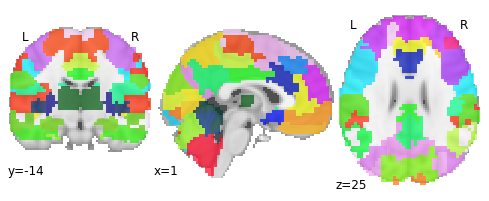

In [6]:
plotting.plot_roi(atlas_filename, draw_cross=False)

# Generating Time-series of Single Subject

Initialize the masker from which we will retrieve a 2D array

In [7]:
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, memory='nilearn_cache', verbose=0)

In [8]:
sub = data.func[0]
conf = data.confounds[0]

time_series = masker.fit_transform(sub, confounds=conf) # Extract brain signal while removing confounds

time_series.shape

(168, 64)

# Correlation Matrices

### For single subject

- Initialize correlation measure, to build a "connectome"
 - Vectorize => ready for our predictive model later on!
 - Non-vectorize => Just to visualize single subect's correlation matrix

In [9]:
vectorized_correlation_measure = ConnectivityMeasure(kind='correlation', discard_diagonal=True, vectorize=True)
nonvectorized_correlation_measure = ConnectivityMeasure(kind='correlation', discard_diagonal=True)

In [10]:
nonvectorized_correlation_matrix = nonvectorized_correlation_measure.fit_transform([time_series])[0]
vectorized_correlation_matrix = vectorized_correlation_measure.fit_transform([time_series])[0]
print('Nonvectorized Correlation Matrix.shape: {}'.format(nonvectorized_correlation_matrix.shape))
print('vectorized_correlation_matrix.shape: {}'.format(vectorized_correlation_matrix.shape))

Nonvectorized Correlation Matrix.shape: (64, 64)
vectorized_correlation_matrix.shape: (2016,)


Plotting Correlation Matrix 

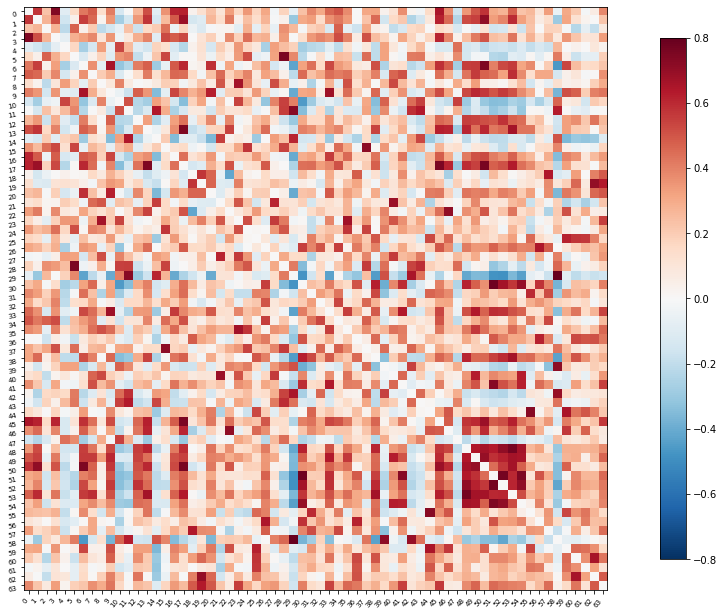

In [20]:
np.fill_diagonal(nonvectorized_correlation_matrix, 0)
plotting.plot_matrix(nonvectorized_correlation_matrix, figure=(12, 12), 
                     labels=range(time_series.shape[-1]), 
                     vmax=0.8, vmin=-0.8, reorder=False)

# Features Dataframe for Machine Learning 

In [10]:
from tqdm import tqdm
import pickle

Correlation between timeseries of Regions to form features dataset

In [13]:
all_features = [] 

for i,sub in enumerate(tqdm(data.func)):
    time_series = masker.fit_transform(sub, confounds=data.confounds[i])
    vectorized_correlation_matrix = vectorized_correlation_measure.fit_transform([time_series])[0]
    all_features.append(vectorized_correlation_matrix)

100%|██████████| 155/155 [14:42<00:00,  5.69s/it] 


In [15]:
all_features_nonvec = [] 

for i,sub in enumerate(tqdm(data.func)):
    time_series = masker.fit_transform(sub, confounds=data.confounds[i])
    nonvectorized_correlation_matrix = nonvectorized_correlation_measure.fit_transform([time_series])[0]
    all_features_nonvec.append(nonvectorized_correlation_matrix)

100%|██████████| 155/155 [02:40<00:00,  1.04s/it]


In [16]:
mean_correlation_matrix = nonvectorized_correlation_measure.mean_
coordinates = plotting.find_parcellation_cut_coords(labels_img = atlas_filename)

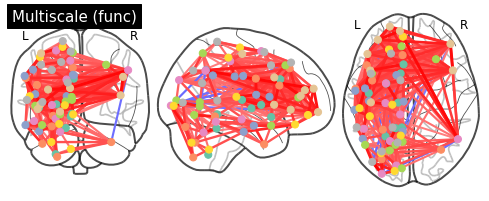

In [17]:
plotting.plot_connectome(mean_correlation_matrix, coordinates,
                         edge_threshold="80%",
                         title='Multiscale (func)')

Convert features list to dataframe and store using pickle

In [69]:
df_features = pd.DataFrame(all_features)
pickle_out = open(os.path.join(os.path.abspath('..'),"Data/features.pickle"),"wb")
pickle.dump(df_features, pickle_out)
pickle_out.close()

In [13]:
pickle_in = open(os.path.join(os.path.abspath('..'),"Data/features.pickle"),"rb")
df_features = pickle.load(pickle_in)
pickle_in.close()

In [14]:
print(df_features.shape)
df_features.head()

(155, 2016)


,0,1,2,3,4,5,6,7,8,9,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,0.232860,-0.043625,0.092009,0.465798,0.295241,0.091350,0.000028,-0.000019,0.000017,-0.000013,...,0.377468,0.135321,0.214588,0.449405,0.231941,0.387250,0.166260,0.551690,0.378682,0.475202
1,0.467246,-0.119457,-0.062547,0.472326,0.376036,0.035121,0.000221,0.000038,-0.000191,0.000221,...,0.072512,0.272233,-0.032882,0.391810,0.232658,0.548074,-0.242473,0.032048,0.095475,0.230578
2,0.448596,0.130983,0.316571,0.662571,0.272684,0.098411,-0.023168,-0.069897,0.066056,0.024636,...,0.516681,0.628576,0.405334,0.591906,0.656595,0.554171,0.376697,0.512734,0.457288,0.640499
3,0.236547,0.048036,0.002236,0.448658,0.142590,0.068359,-0.053419,-0.029784,0.014794,0.036110,...,-0.070190,0.530982,0.072605,0.175955,0.194926,0.170638,0.191752,0.135061,0.135847,0.368537
4,0.244007,0.083132,0.342197,0.341674,-0.076095,-0.086215,0.135303,-0.107674,-0.012754,0.168019,...,0.278559,0.092597,0.269093,0.413449,0.128707,0.338674,0.145776,0.345804,0.177099,0.419354


<IPython.core.display.Javascript object>


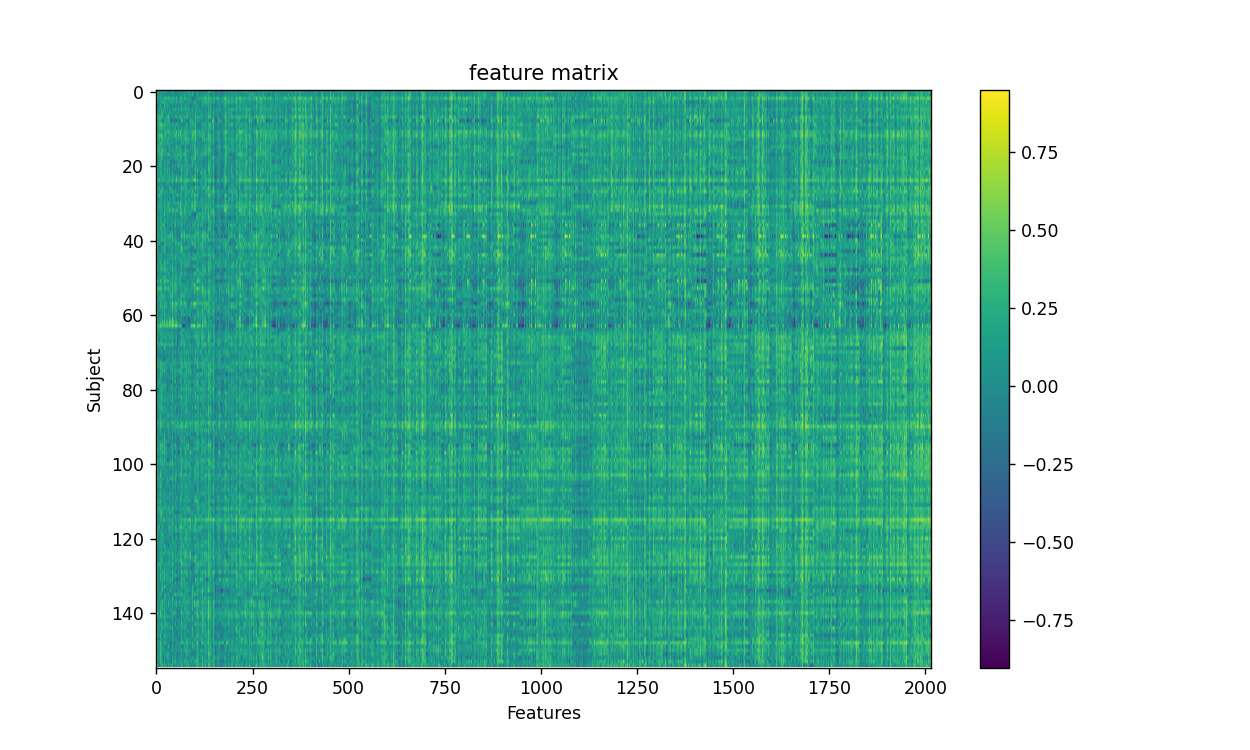

[Text(0, 0.5, 'Subject'),
 Text(0.5, 0, 'Features'),
 Text(0.5, 1.0, 'feature matrix')]

In [57]:
fig, ax = plt.subplots(1, figsize = (10,6))
img = ax.imshow(df_features, aspect = 'auto')
fig.colorbar(img, ax = ax)
ax.set(title = 'feature matrix', xlabel = 'Features', ylabel = 'Subject')

In [16]:
df_features.describe()

,0,1,2,3,4,5,6,7,8,9,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,...,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,0.438603,0.115481,0.138229,0.495525,0.325086,0.139913,0.035265,0.049362,0.043459,0.066615,...,0.318569,0.277929,0.157189,0.431242,0.368352,0.484600,0.112711,0.281814,0.249751,0.400408
std,0.136199,0.139860,0.150602,0.138108,0.139446,0.142665,0.129211,0.143999,0.132486,0.152607,...,0.232029,0.212595,0.203954,0.182167,0.186938,0.174347,0.221107,0.221537,0.201770,0.177003
min,-0.040300,-0.259276,-0.386562,0.060856,-0.076095,-0.190003,-0.255162,-0.353081,-0.287570,-0.274818,...,-0.714710,-0.309452,-0.402019,-0.249006,-0.093113,-0.098144,-0.744601,-0.684216,-0.376467,-0.135318
25%,0.363638,0.026928,0.043248,0.417529,0.249166,0.039026,-0.034033,-0.025750,-0.041741,-0.009376,...,0.182286,0.138482,0.015483,0.319277,0.255541,0.386803,-0.010240,0.156909,0.102142,0.305254
50%,0.454781,0.117421,0.134308,0.509799,0.345709,0.148410,0.000082,0.014644,0.011904,0.024636,...,0.361410,0.276618,0.165106,0.465682,0.394346,0.514011,0.132403,0.305244,0.265340,0.424061
75%,0.532945,0.218490,0.245897,0.596292,0.415149,0.233340,0.116784,0.124545,0.113476,0.149484,...,0.468882,0.418125,0.307049,0.564425,0.482785,0.596482,0.269939,0.449185,0.392385,0.523710
max,0.726722,0.536872,0.565612,0.777401,0.607736,0.544285,0.450133,0.465348,0.430848,0.515875,...,0.769479,0.742385,0.659952,0.818867,0.855198,0.814587,0.601870,0.709806,0.783219,0.749233


# Target (Labels) DataFrame for Machine Learning

In [17]:
from sklearn import preprocessing


In [71]:
pheno = pd.DataFrame(pheno)
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness
0,sub-pixar123,27.06,Adult,adult,F,R
1,sub-pixar124,33.44,Adult,adult,M,R
2,sub-pixar125,31.00,Adult,adult,M,R
3,sub-pixar126,19.00,Adult,adult,F,R
4,sub-pixar127,23.00,Adult,adult,F,R


Extract Gender Column to another DataFrame df_labels

In [72]:
df_labels = pd.DataFrame(pheno['Gender'])
df_labels

,Gender
0,F
1,M
2,M
3,F
4,F
...,...
150,F
151,F
152,F
153,F


Convert Categorical Variable "Gender" to numeric 

In [73]:
le = preprocessing.LabelEncoder()
le.fit(df_labels.values)
print(le.classes_)
df_labels = pd.DataFrame(data=le.transform(df_labels.values),columns=['Gender'])
df_labels.head()

['F' 'M']


,Gender
0,0
1,1
2,1
3,0
4,0


In [16]:
pickle_in = open(os.path.join(os.path.abspath('..'),"Data/labels.pickle"),"rb")
df_labels = pickle.load(pickle_in)
pickle_in.close()

Plot a Bar Chart depicting the count of each unique value in Gender column

In [17]:
df_labels['Gender'].value_counts().iplot(kind='bar', xaxis_title="Gender", yaxis_title="Count")


Total Count of each unique value of Gender

In [75]:
df_labels['Gender'].value_counts()

0    84
1    71
Name: Gender, dtype: int64

A combined data frame with all the features and labels columns

In [43]:
df_combined = pd.concat([df_features,df_labels], axis=1, sort=False)
print(df_combined.shape)
print(type(df_combined))
df_combined.head()


(155, 2017)
<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,Gender
0,0.232860,-0.043625,0.092009,0.465798,0.295241,0.091350,0.000028,-0.000019,0.000017,-0.000013,...,0.135321,0.214588,0.449405,0.231941,0.387250,0.166260,0.551690,0.378682,0.475202,0
1,0.467246,-0.119457,-0.062547,0.472326,0.376036,0.035121,0.000221,0.000038,-0.000191,0.000221,...,0.272233,-0.032882,0.391810,0.232658,0.548074,-0.242473,0.032048,0.095475,0.230578,1
2,0.448596,0.130983,0.316571,0.662571,0.272684,0.098411,-0.023168,-0.069897,0.066056,0.024636,...,0.628576,0.405334,0.591906,0.656595,0.554171,0.376697,0.512734,0.457288,0.640499,1
3,0.236547,0.048036,0.002236,0.448658,0.142590,0.068359,-0.053419,-0.029784,0.014794,0.036110,...,0.530982,0.072605,0.175955,0.194926,0.170638,0.191752,0.135061,0.135847,0.368537,0
4,0.244007,0.083132,0.342197,0.341674,-0.076095,-0.086215,0.135303,-0.107674,-0.012754,0.168019,...,0.092597,0.269093,0.413449,0.128707,0.338674,0.145776,0.345804,0.177099,0.419354,0


In [77]:
df_combined.Gender.unique()

array([0, 1])

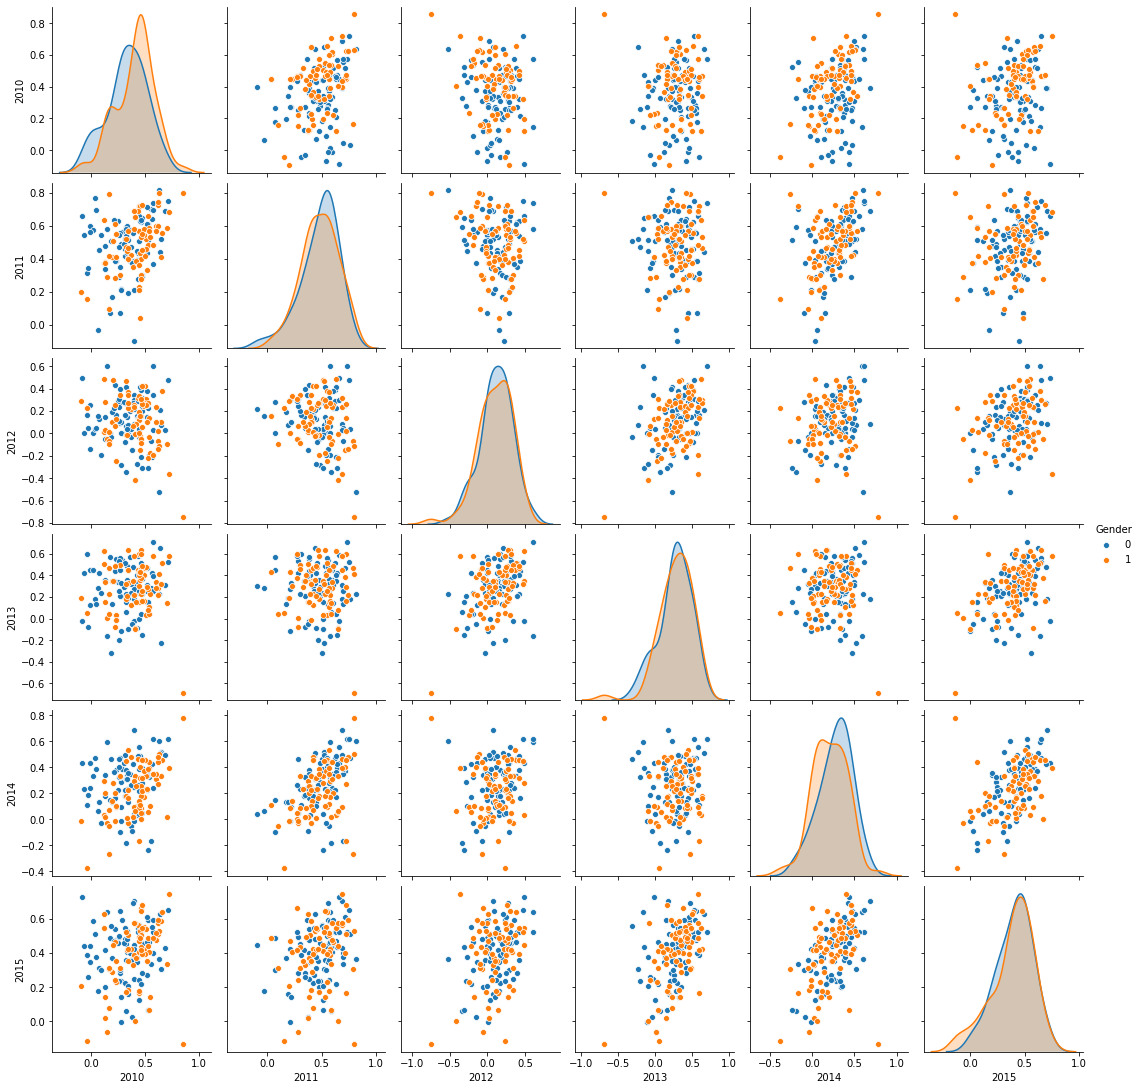

In [49]:
sns.pairplot(df_combined.iloc[:,2010:2017], hue="Gender", kind ='scatter')

In [95]:
pickle_out = open(os.path.join(os.path.abspath('..'),"Data/labels.pickle"),"wb")
pickle.dump(df_labels, pickle_out)
pickle_out.close()